# 🚀 Optimized Bidirectional LSTM for Order Prediction
## Focus: BiLSTM with Comprehensive Model Management

### Current Performance (Your Results):
- ✅ **MAE: 3.59 days** (Excellent! Much better than baseline 6.17)
- ✅ **Within 7 days: 91.9%** (Outstanding accuracy)
- ✅ **Within 14 days: 96.3%** (Very high precision)

### This Notebook Includes:
1. **Enhanced BiLSTM Architecture** (building on your success)
2. **Comprehensive Model Saving** (multiple formats)
3. **Model Versioning & Checkpointing**
4. **Easy Model Loading & Inference**
5. **Performance Monitoring & Logging**

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras -q

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import json
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, 
    BatchNormalization, Attention
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, CSVLogger, TensorBoard
)
from tensorflow.keras.regularizers import l1_l2

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Libraries imported successfully!")
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"🎲 Random seed set to: {RANDOM_SEED}")

✅ Libraries imported successfully!
📦 TensorFlow version: 2.20.0
🎲 Random seed set to: 42


## 🔧 Configuration & Model Directories

In [3]:
# Create directory structure for model management
MODEL_DIR = 'models'
CHECKPOINT_DIR = os.path.join(MODEL_DIR, 'checkpoints')
LOGS_DIR = os.path.join(MODEL_DIR, 'logs')
SCALER_DIR = os.path.join(MODEL_DIR, 'scalers')
METADATA_DIR = os.path.join(MODEL_DIR, 'metadata')

# Create directories
for directory in [MODEL_DIR, CHECKPOINT_DIR, LOGS_DIR, SCALER_DIR, METADATA_DIR]:
    os.makedirs(directory, exist_ok=True)

# Configuration
CONFIG = {
    'model_name': 'bilstm_order_prediction',
    'version': '1.0',
    'random_seed': RANDOM_SEED,
    'test_size': 0.2,
    'validation_split': 0.15,
    'batch_size': 64,
    'epochs': 150,
    'learning_rate': 0.001,
    'patience_early_stop': 20,
    'patience_reduce_lr': 10,
}

print("✅ Directory structure created:")
print(f"   📁 Models: {MODEL_DIR}")
print(f"   📁 Checkpoints: {CHECKPOINT_DIR}")
print(f"   📁 Logs: {LOGS_DIR}")
print(f"   📁 Scalers: {SCALER_DIR}")
print(f"   📁 Metadata: {METADATA_DIR}")
print(f"\n⚙️  Configuration loaded")

✅ Directory structure created:
   📁 Models: models
   📁 Checkpoints: models\checkpoints
   📁 Logs: models\logs
   📁 Scalers: models\scalers
   📁 Metadata: models\metadata

⚙️  Configuration loaded


## 🎯 Enhanced Feature Engineering
### Based on your successful implementation + additional improvements

In [4]:
def create_enhanced_features(df):
    """
    Create enhanced features optimized for BiLSTM
    Based on your successful implementation (3.59 MAE)
    """
    df = df.copy()
    
    # Convert dates
    df['sales_order_creation_date'] = pd.to_datetime(df['sales_order_creation_date'])
    df['actual_expedition_date'] = pd.to_datetime(df['actual_expedition_date'])
    
    # Sort by client and date
    df = df.sort_values(['client_name', 'actual_expedition_date'])
    
    print("Creating features...")
    
    # ========================================================================
    # 1. CORE TEMPORAL FEATURES (Most Important)
    # ========================================================================
    
    # Days since last order
    df['days_since_last_order'] = df.groupby('client_name')['actual_expedition_date'].diff().dt.days
    
    # Historical statistics
    df['days_since_last_order_mean'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().mean()
    )
    df['days_since_last_order_std'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().std()
    )
    df['days_since_last_order_min'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().min()
    )
    df['days_since_last_order_max'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.expanding().max()
    )
    
    # ========================================================================
    # 2. CLIENT BEHAVIOR METRICS
    # ========================================================================
    
    # Order sequence and frequency
    df['order_sequence'] = df.groupby('client_name').cumcount() + 1
    df['client_lifetime_days'] = df.groupby('client_name')['actual_expedition_date'].transform(
        lambda x: (x - x.min()).dt.days
    )
    df['order_frequency_per_month'] = (df['order_sequence'] / (df['client_lifetime_days'] / 30)).replace(
        [np.inf, -np.inf], 0
    )
    
    # Order counts
    df['total_amount_delivered_tm_count'] = df.groupby('client_name').cumcount() + 1
    
    # ========================================================================
    # 3. ROLLING WINDOW FEATURES (Multiple Horizons)
    # ========================================================================
    
    for window in [3, 5, 7, 10]:
        # Days between orders
        df[f'rolling_avg_days_{window}'] = df.groupby('client_name')['days_since_last_order'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_days_{window}'] = df.groupby('client_name')['days_since_last_order'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        
        # Quantity patterns
        df[f'rolling_avg_quantity_{window}'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_quantity_{window}'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    # ========================================================================
    # 4. TREND & MOMENTUM FEATURES
    # ========================================================================
    
    # Ordering frequency trend
    df['order_frequency_trend'] = df.groupby('client_name')['order_frequency_per_month'].transform(
        lambda x: x.diff()
    )
    
    # Days since last order trend
    df['days_trend'] = df.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.diff()
    )
    
    # Quantity trend
    df['quantity_trend'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.diff()
    )
    
    # Recent vs historical comparison
    df['recent_vs_historical_frequency'] = df['rolling_avg_days_3'] / (df['days_since_last_order_mean'] + 1)
    
    # ========================================================================
    # 5. CLIENT MATURITY & CONSISTENCY
    # ========================================================================
    
    # Maturity level
    df['client_maturity'] = pd.cut(
        df['total_amount_delivered_tm_count'],
        bins=[0, 5, 20, np.inf],
        labels=[0, 1, 2]  # 0=new, 1=established, 2=veteran
    ).astype(int)
    
    # Consistency score (inverse of coefficient of variation)
    df['ordering_consistency'] = df['days_since_last_order_mean'] / (df['days_since_last_order_std'] + 1)
    
    # High frequency flag
    df['is_high_frequency'] = (df['order_frequency_per_month'] > df['order_frequency_per_month'].median()).astype(int)
    
    # ========================================================================
    # 6. QUANTITY FEATURES
    # ========================================================================
    
    df['total_amount_delivered_tm_mean'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.expanding().mean()
    )
    df['total_amount_delivered_tm_std'] = df.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.expanding().std()
    )
    
    # ========================================================================
    # 7. MINIMAL TEMPORAL CONTEXT (Lower priority but keep for context)
    # ========================================================================
    
    df['order_month'] = df['actual_expedition_date'].dt.month
    df['order_quarter'] = df['actual_expedition_date'].dt.quarter
    df['order_day_of_month'] = df['actual_expedition_date'].dt.day
    
    # ========================================================================
    # 8. TARGET VARIABLE
    # ========================================================================
    
    df['days_until_next_order'] = df.groupby('client_name')['days_since_last_order'].shift(-1)
    
    # Fill missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"✅ Feature engineering complete!")
    print(f"   Total features created: {len(numeric_cols)}")
    
    return df

print("✅ Feature engineering function defined")

✅ Feature engineering function defined


## 🎯 Intelligent Feature Selection

In [5]:
def select_best_features():
    """
    Select features optimized for BiLSTM based on importance analysis
    """
    
    # HIGH PRIORITY - Core temporal features
    core_features = [
        'days_since_last_order',
        'days_since_last_order_mean',
        'days_since_last_order_std',
        'days_since_last_order_min',
        'days_since_last_order_max',
    ]
    
    # HIGH PRIORITY - Client behavior
    behavior_features = [
        'order_frequency_per_month',
        'total_amount_delivered_tm_count',
        'order_sequence',
        'client_lifetime_days',
    ]
    
    # MEDIUM PRIORITY - Rolling windows (multiple horizons)
    rolling_features = []
    for window in [3, 5, 7, 10]:
        rolling_features.extend([
            f'rolling_avg_days_{window}',
            f'rolling_std_days_{window}',
            f'rolling_avg_quantity_{window}',
            f'rolling_std_quantity_{window}',
        ])
    
    # MEDIUM PRIORITY - Trends
    trend_features = [
        'order_frequency_trend',
        'days_trend',
        'quantity_trend',
        'recent_vs_historical_frequency',
    ]
    
    # LOW PRIORITY - Consistency & maturity
    meta_features = [
        'client_maturity',
        'ordering_consistency',
        'is_high_frequency',
    ]
    
    # LOW PRIORITY - Quantity
    quantity_features = [
        'total_amount_delivered_tm',
        'total_amount_delivered_tm_mean',
        'total_amount_delivered_tm_std',
    ]
    
    # MINIMAL - Temporal context
    temporal_features = [
        'order_month',
        'order_quarter',
        'order_day_of_month',
    ]
    
    # Combine all
    selected_features = (
        core_features + 
        behavior_features + 
        rolling_features + 
        trend_features + 
        meta_features + 
        quantity_features + 
        temporal_features
    )
    
    print(f"\n📊 Feature Selection Summary:")
    print(f"   Core Temporal: {len(core_features)}")
    print(f"   Behavior: {len(behavior_features)}")
    print(f"   Rolling Windows: {len(rolling_features)}")
    print(f"   Trends: {len(trend_features)}")
    print(f"   Meta: {len(meta_features)}")
    print(f"   Quantity: {len(quantity_features)}")
    print(f"   Temporal: {len(temporal_features)}")
    print(f"   " + "="*50)
    print(f"   Total Selected: {len(selected_features)}")
    
    return selected_features

print("✅ Feature selection function defined")

✅ Feature selection function defined


## 🔧 Data Preparation with Model Persistence

In [6]:
def prepare_data_for_lstm(df, selected_features, config):
    """
    Prepare data for LSTM with scaler persistence
    """
    
    # Remove rows without target
    df_clean = df.dropna(subset=['days_until_next_order']).copy()
    
    # Separate features and target
    X = df_clean[selected_features].copy()
    y = df_clean['days_until_next_order'].copy()
    
    # Split data (temporal split - no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=config['test_size'], 
        random_state=config['random_seed'],
        shuffle=False  # Preserve temporal order
    )
    
    # Scale features using RobustScaler (better for outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for LSTM: (samples, timesteps, features)
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    # Save scaler
    scaler_path = os.path.join(SCALER_DIR, 'feature_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"\n💾 Scaler saved to: {scaler_path}")
    
    # Save feature names
    feature_path = os.path.join(METADATA_DIR, 'feature_names.json')
    with open(feature_path, 'w') as f:
        json.dump(selected_features, f, indent=2)
    print(f"💾 Feature names saved to: {feature_path}")
    
    print(f"\n📊 Data Preparation Summary:")
    print(f"   Training samples: {X_train_lstm.shape[0]:,}")
    print(f"   Test samples: {X_test_lstm.shape[0]:,}")
    print(f"   Number of features: {X_train_lstm.shape[2]}")
    print(f"   LSTM input shape: {X_train_lstm.shape}")
    print(f"   Target mean (train): {y_train.mean():.2f} days")
    print(f"   Target std (train): {y_train.std():.2f} days")
    
    return {
        'X_train': X_train_lstm,
        'X_test': X_test_lstm,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': selected_features
    }

print("✅ Data preparation function defined")

✅ Data preparation function defined


## 🧠 Enhanced Bidirectional LSTM Architecture

In [7]:
def build_enhanced_bilstm(input_shape, config):
    """
    Build enhanced BiLSTM based on your successful architecture
    Optimized for 3.59 MAE performance
    """
    
    model = Sequential([
        # First Bidirectional LSTM layer with attention
        Bidirectional(
            LSTM(
                128,
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                recurrent_dropout=0.1
            ),
            input_shape=input_shape
        ),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Bidirectional LSTM layer
        Bidirectional(
            LSTM(
                64,
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                recurrent_dropout=0.1
            )
        ),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1, activation='linear')
    ])
    
    # Compile with Huber loss (robust to outliers)
    optimizer = keras.optimizers.Adam(
        learning_rate=config['learning_rate'],
        clipnorm=1.0  # Gradient clipping
    )
    
    model.compile(
        optimizer=optimizer,
        loss='huber',  # Robust to outliers
        metrics=['mae', 'mse']
    )
    
    return model

print("✅ Model architecture function defined")

✅ Model architecture function defined


## 📊 Comprehensive Training Callbacks

In [8]:
def create_callbacks(config):
    """
    Create comprehensive callbacks for training
    """
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    callbacks = [
        # 1. Early Stopping
        EarlyStopping(
            monitor='val_loss',
            patience=config['patience_early_stop'],
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        
        # 2. Reduce Learning Rate on Plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=config['patience_reduce_lr'],
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        # 3. Model Checkpoint (save best model)
        ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, f'best_model_{timestamp}.h5'),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='min'
        ),
        
        # 4. CSV Logger (detailed training history)
        CSVLogger(
            filename=os.path.join(LOGS_DIR, f'training_log_{timestamp}.csv'),
            append=False
        ),
        
        # 5. TensorBoard (optional, for visualization)
        TensorBoard(
            log_dir=os.path.join(LOGS_DIR, f'tensorboard_{timestamp}'),
            histogram_freq=1,
            write_graph=True
        )
    ]
    
    print(f"\n📋 Callbacks configured:")
    print(f"   ✓ Early Stopping (patience={config['patience_early_stop']})")
    print(f"   ✓ Reduce LR on Plateau (patience={config['patience_reduce_lr']})")
    print(f"   ✓ Model Checkpoint")
    print(f"   ✓ CSV Logger")
    print(f"   ✓ TensorBoard")
    
    return callbacks, timestamp

print("✅ Callbacks function defined")

✅ Callbacks function defined


## 🚀 Model Training with Progress Tracking

In [9]:
def train_bilstm(model, data, config, callbacks):
    """
    Train BiLSTM model with comprehensive monitoring
    """
    
    print("\n" + "="*80)
    print("🚀 STARTING MODEL TRAINING")
    print("="*80)
    
    training_start = datetime.now()
    
    history = model.fit(
        data['X_train'], data['y_train'],
        validation_split=config['validation_split'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    training_duration = datetime.now() - training_start
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE")
    print("="*80)
    print(f"   Duration: {training_duration}")
    print(f"   Epochs completed: {len(history.history['loss'])}")
    print(f"   Best val_loss: {min(history.history['val_loss']):.4f}")
    print(f"   Best val_mae: {min(history.history['val_mae']):.4f}")
    
    return model, history

print("✅ Training function defined")

✅ Training function defined


In [ ]:
# FIXED VERSION - Use this instead of the previous save_complete_model function
def save_complete_model(model, data, config, history, timestamp):
    """
    Save model in multiple formats with metadata (Keras 3 compatible)
    """
    
    print("\n" + "="*80)
    print("💾 SAVING MODEL")
    print("="*80)
    
    model_name = f"{config['model_name']}_v{config['version']}_{timestamp}"
    
    # 1. Save full model (.h5 format)
    h5_path = os.path.join(MODEL_DIR, f'{model_name}.h5')
    model.save(h5_path)
    print(f"✅ Model saved (HDF5): {h5_path}")
    
    # 2. Save model in native Keras format (Keras 3 format)
    keras_path = os.path.join(MODEL_DIR, f'{model_name}.keras')
    model.save(keras_path)
    print(f"✅ Model saved (Keras format): {keras_path}")
    
    # 3. Save model weights only
    weights_path = os.path.join(MODEL_DIR, f'{model_name}_weights.h5')
    model.save_weights(weights_path)
    print(f"✅ Weights saved: {weights_path}")
    
    # 4. Save model architecture (JSON)
    architecture_path = os.path.join(METADATA_DIR, f'{model_name}_architecture.json')
    with open(architecture_path, 'w') as f:
        f.write(model.to_json())
    print(f"✅ Architecture saved: {architecture_path}")
    
    # 5. Save training history
    history_path = os.path.join(METADATA_DIR, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Training history saved: {history_path}")
    
    # 6. Save metadata (configuration + performance)
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'config': config,
        'training_info': {
            'total_epochs': len(history.history['loss']),
            'best_val_loss': float(min(history.history['val_loss'])),
            'best_val_mae': float(min(history.history['val_mae'])),
            'final_train_loss': float(history.history['loss'][-1]),
            'final_train_mae': float(history.history['mae'][-1]),
        },
        'data_info': {
            'n_features': len(data['feature_names']),
            'n_train_samples': int(data['X_train'].shape[0]),
            'n_test_samples': int(data['X_test'].shape[0]),
            'target_mean': float(data['y_train'].mean()),
            'target_std': float(data['y_train'].std()),
        }
    }
    
    metadata_path = os.path.join(METADATA_DIR, f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_path}")
    
    # 7. Create a "latest" symlink or copy
    latest_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    import shutil
    shutil.copy2(h5_path, latest_path)
    print(f"✅ Latest model link created: {latest_path}")
    
    print("\n" + "="*80)
    print("🎉 MODEL SAVED SUCCESSFULLY")
    print("="*80)
    print(f"\n📦 Saved artifacts:")
    print(f"   1. Full model (.h5): {h5_path}")
    print(f"   2. Keras format (.keras): {keras_path}")
    print(f"   3. Weights only: {weights_path}")
    print(f"   4. Architecture (JSON): {architecture_path}")
    print(f"   5. Training history: {history_path}")
    print(f"   6. Metadata: {metadata_path}")
    print(f"   7. Latest model: {latest_path}")
    
    return model_name, metadata

print("✅ FIXED Model saving function defined - ready to use!")


## 💾 Comprehensive Model Saving

In [10]:
def save_complete_model(model, data, config, history, timestamp):
    """
    Save model in multiple formats with metadata
    """
    
    print("\n" + "="*80)
    print("💾 SAVING MODEL")
    print("="*80)
    
    model_name = f"{config['model_name']}_v{config['version']}_{timestamp}"
    
    # 1. Save full model (.h5 format)
    h5_path = os.path.join(MODEL_DIR, f'{model_name}.h5')
    model.save(h5_path)
    print(f"✅ Model saved (HDF5): {h5_path}")
    
    # 2. Save model in SavedModel format (TensorFlow)
    savedmodel_path = os.path.join(MODEL_DIR, f'{model_name}_savedmodel')
    model.save(savedmodel_path, save_format='tf')
    print(f"✅ Model saved (SavedModel): {savedmodel_path}")
    
    # 3. Save model weights only
    weights_path = os.path.join(MODEL_DIR, f'{model_name}_weights.h5')
    model.save_weights(weights_path)
    print(f"✅ Weights saved: {weights_path}")
    
    # 4. Save model architecture (JSON)
    architecture_path = os.path.join(METADATA_DIR, f'{model_name}_architecture.json')
    with open(architecture_path, 'w') as f:
        f.write(model.to_json())
    print(f"✅ Architecture saved: {architecture_path}")
    
    # 5. Save training history
    history_path = os.path.join(METADATA_DIR, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Training history saved: {history_path}")
    
    # 6. Save metadata (configuration + performance)
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'config': config,
        'training_info': {
            'total_epochs': len(history.history['loss']),
            'best_val_loss': float(min(history.history['val_loss'])),
            'best_val_mae': float(min(history.history['val_mae'])),
            'final_train_loss': float(history.history['loss'][-1]),
            'final_train_mae': float(history.history['mae'][-1]),
        },
        'data_info': {
            'n_features': len(data['feature_names']),
            'n_train_samples': int(data['X_train'].shape[0]),
            'n_test_samples': int(data['X_test'].shape[0]),
            'target_mean': float(data['y_train'].mean()),
            'target_std': float(data['y_train'].std()),
        }
    }
    
    metadata_path = os.path.join(METADATA_DIR, f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_path}")
    
    # 7. Create a "latest" symlink or copy
    latest_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    import shutil
    shutil.copy2(h5_path, latest_path)
    print(f"✅ Latest model link created: {latest_path}")
    
    print("\n" + "="*80)
    print("🎉 MODEL SAVED SUCCESSFULLY")
    print("="*80)
    print(f"\n📦 Saved artifacts:")
    print(f"   1. Full model (.h5): {h5_path}")
    print(f"   2. SavedModel format: {savedmodel_path}")
    print(f"   3. Weights only: {weights_path}")
    print(f"   4. Architecture (JSON): {architecture_path}")
    print(f"   5. Training history: {history_path}")
    print(f"   6. Metadata: {metadata_path}")
    print(f"   7. Latest model: {latest_path}")
    
    return model_name, metadata

print("✅ Model saving function defined")

✅ Model saving function defined


## 📊 Model Evaluation & Performance Analysis

In [11]:
def evaluate_model_comprehensive(model, X_test, y_test):
    """
    Comprehensive model evaluation
    """
    
    print("\n" + "="*80)
    print("📊 MODEL EVALUATION")
    print("="*80)
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Median absolute error
    median_ae = np.median(np.abs(y_test - y_pred))
    
    # Mean Absolute Percentage Error (handle division by zero)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, 1))) * 100
    
    # Prediction accuracy at different thresholds
    within_3_days = np.mean(np.abs(y_test - y_pred) <= 3) * 100
    within_7_days = np.mean(np.abs(y_test - y_pred) <= 7) * 100
    within_14_days = np.mean(np.abs(y_test - y_pred) <= 14) * 100
    within_30_days = np.mean(np.abs(y_test - y_pred) <= 30) * 100
    
    print(f"\n🎯 Core Metrics:")
    print(f"   MAE (Mean Absolute Error):      {mae:.2f} days")
    print(f"   RMSE (Root Mean Squared Error): {rmse:.2f} days")
    print(f"   R² Score:                       {r2:.4f}")
    print(f"   Median Absolute Error:          {median_ae:.2f} days")
    print(f"   MAPE:                           {mape:.2f}%")
    
    print(f"\n🎯 Prediction Accuracy:")
    print(f"   Within  3 days:  {within_3_days:5.1f}%")
    print(f"   Within  7 days:  {within_7_days:5.1f}%")
    print(f"   Within 14 days:  {within_14_days:5.1f}%")
    print(f"   Within 30 days:  {within_30_days:5.1f}%")
    
    # Error distribution
    errors = y_test - y_pred
    print(f"\n📈 Error Distribution:")
    print(f"   Mean error:      {errors.mean():6.2f} days")
    print(f"   Std error:       {errors.std():6.2f} days")
    print(f"   Min error:       {errors.min():6.2f} days")
    print(f"   25th percentile: {np.percentile(errors, 25):6.2f} days")
    print(f"   50th percentile: {np.percentile(errors, 50):6.2f} days")
    print(f"   75th percentile: {np.percentile(errors, 75):6.2f} days")
    print(f"   Max error:       {errors.max():6.2f} days")
    
    results = {
        'predictions': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'median_ae': median_ae,
        'mape': mape,
        'within_3': within_3_days,
        'within_7': within_7_days,
        'within_14': within_14_days,
        'within_30': within_30_days,
        'errors': errors
    }
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 📈 Visualization Functions

In [12]:
def plot_training_history(history, save_path=None):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE (days)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MSE
    axes[1, 0].plot(history.history['mse'], label='Train MSE', linewidth=2)
    axes[1, 0].plot(history.history['val_mse'], label='Val MSE', linewidth=2)
    axes[1, 0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
        axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Training history plot saved: {save_path}")
    
    plt.show()

def plot_predictions(y_test, y_pred, save_path=None):
    """
    Plot predictions vs actual
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Days', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicted Days', fontsize=12, fontweight='bold')
    axes[0].set_title('Predictions vs Actual', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    errors = y_test - y_pred
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    axes[1].set_xlabel('Prediction Error (days)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Predictions plot saved: {save_path}")
    
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


## 🔄 Model Loading & Inference Functions

In [13]:
def load_complete_model(model_path=None):
    """
    Load a saved model with all its components
    """
    
    if model_path is None:
        model_path = os.path.join(MODEL_DIR, 'latest_model.h5')
    
    print(f"\n📂 Loading model from: {model_path}")
    
    # Load model
    model = load_model(model_path)
    print("✅ Model loaded successfully")
    
    # Load scaler
    scaler_path = os.path.join(SCALER_DIR, 'feature_scaler.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✅ Scaler loaded from: {scaler_path}")
    
    # Load feature names
    feature_path = os.path.join(METADATA_DIR, 'feature_names.json')
    with open(feature_path, 'r') as f:
        feature_names = json.load(f)
    print(f"✅ Feature names loaded from: {feature_path}")
    
    return {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names
    }

def predict_new_data(model_components, new_data):
    """
    Make predictions on new data
    
    Args:
        model_components: dict with 'model', 'scaler', 'feature_names'
        new_data: DataFrame with features
    """
    
    # Extract required features
    X_new = new_data[model_components['feature_names']]
    
    # Scale features
    X_scaled = model_components['scaler'].transform(X_new)
    
    # Reshape for LSTM
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Predict
    predictions = model_components['model'].predict(X_lstm, verbose=0).flatten()
    
    return predictions

print("✅ Loading and inference functions defined")

✅ Loading and inference functions defined


## 🚀 COMPLETE PIPELINE EXECUTION
### Run this section to train and save your model

In [14]:
"""
MAIN EXECUTION PIPELINE

Uncomment and run this section to:
1. Load your data
2. Create enhanced features
3. Train BiLSTM model
4. Save model in multiple formats
5. Evaluate performance
6. Generate visualizations
"""

# Step 1: Load your data
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')
print("⚠️  Step 1: Load your data here")

# Step 2: Create features
df_features = create_enhanced_features(df)
print("⚠️  Step 2: Create features")

# Step 3: Select features
selected_features = select_best_features()
print("⚠️  Step 3: Select features")

# Step 4: Prepare data
data = prepare_data_for_lstm(df_features, selected_features, CONFIG)
print("⚠️  Step 4: Prepare data")



⚠️  Step 1: Load your data here
Creating features...
✅ Feature engineering complete!
   Total features created: 52
⚠️  Step 2: Create features

📊 Feature Selection Summary:
   Core Temporal: 5
   Behavior: 4
   Rolling Windows: 16
   Trends: 4
   Meta: 3
   Quantity: 3
   Temporal: 3
   Total Selected: 38
⚠️  Step 3: Select features

💾 Scaler saved to: models\scalers\feature_scaler.pkl
💾 Feature names saved to: models\metadata\feature_names.json

📊 Data Preparation Summary:
   Training samples: 12,237
   Test samples: 3,060
   Number of features: 38
   LSTM input shape: (12237, 1, 38)
   Target mean (train): 8.49 days
   Target std (train): 27.65 days
⚠️  Step 4: Prepare data


In [15]:
# Step 5: Build model
input_shape = (data['X_train'].shape[1], data['X_train'].shape[2])
model = build_enhanced_bilstm(input_shape, CONFIG)
print(model.summary())
print("⚠️  Step 5: Build model")

# Step 6: Create callbacks
callbacks, timestamp = create_callbacks(CONFIG)
print("⚠️  Step 6: Create callbacks")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       171,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,033 (1.33 MB)

 Trainable params: 347,137 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

None
⚠️  Step 5: Build model

📋 Callbacks configured:
   ✓ Early Stopping (patience=20)
   ✓ Reduce LR on Plateau (patience=10)
   ✓ Model Checkpoint
   ✓ CSV Logger
   ✓ TensorBoard
⚠️  Step 6: Create callbacks


In [16]:
# Step 7: Train model
model, history = train_bilstm(model, data, CONFIG, callbacks)
print("⚠️  Step 7: Train model")




🚀 STARTING MODEL TRAINING
Epoch 1/150
151/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3607 - mae: 7.5748 - mse: 613.7798
Epoch 1: val_loss improved from None to 9.26434, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 13.8009 - mae: 7.4809 - mse: 728.8240 - val_loss: 9.2643 - val_mae: 4.8088 - val_mse: 392.6970 - learning_rate: 0.0010
Epoch 2/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5910 - mae: 6.4071 - mse: 519.9163
Epoch 2: val_loss improved from 9.26434 to 7.20540, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10.7047 - mae: 6.8828 - mse: 678.4477 - val_loss: 7.2054 - val_mae: 4.0608 - val_mse: 368.1302 - learning_rate: 0.0010
Epoch 3/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2655 - mae: 6.2914 - mse: 507.8294
Epoch 3: val_loss improved from 7.20540 to 6.06968, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5808 - mae: 6.8200 - mse: 666.6655 - val_loss: 6.0697 - val_mae: 3.6965 - val_mse: 350.6574 - learning_rate: 0.0010
Epoch 4/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4634 - mae: 6.2340 - mse: 509.6187
Epoch 4: val_loss improved from 6.06968 to 5.58515, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8534 - mae: 6.7489 - mse: 670.8260 - val_loss: 5.5852 - val_mae: 3.6889 - val_mse: 341.8441 - learning_rate: 0.0010
Epoch 5/150
151/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9926 - mae: 6.1913 - mse: 496.2554
Epoch 5: val_loss improved from 5.58515 to 5.31090, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4595 - mae: 6.7432 - mse: 659.6285 - val_loss: 5.3109 - val_mae: 3.7399 - val_mse: 348.2086 - learning_rate: 0.0010
Epoch 6/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6622 - mae: 6.1694 - mse: 504.6591
Epoch 6: val_loss improved from 5.31090 to 5.18289, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1299 - mae: 6.6899 - mse: 663.0546 - val_loss: 5.1829 - val_mae: 3.8463 - val_mse: 351.9929 - learning_rate: 0.0010
Epoch 7/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4037 - mae: 6.0979 - mse: 505.7035
Epoch 7: val_loss improved from 5.18289 to 4.88590, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8970 - mae: 6.6298 - mse: 663.8991 - val_loss: 4.8859 - val_mae: 3.6997 - val_mse: 342.9749 - learning_rate: 0.0010
Epoch 8/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2665 - mae: 6.1166 - mse: 497.4639
Epoch 8: val_loss improved from 4.88590 to 4.78077, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7281 - mae: 6.6049 - mse: 658.8817 - val_loss: 4.7808 - val_mae: 3.7185 - val_mse: 340.7092 - learning_rate: 0.0010
Epoch 9/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1042 - mae: 6.0761 - mse: 505.4388
Epoch 9: val_loss improved from 4.78077 to 4.64148, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5871 - mae: 6.5906 - mse: 664.3047 - val_loss: 4.6415 - val_mae: 3.6988 - val_mse: 346.0160 - learning_rate: 0.0010
Epoch 10/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0004 - mae: 6.0854 - mse: 507.6298
Epoch 10: val_loss improved from 4.64148 to 4.58936, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5228 - mae: 6.6262 - mse: 665.3832 - val_loss: 4.5894 - val_mae: 3.7496 - val_mse: 352.6217 - learning_rate: 0.0010
Epoch 11/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9418 - mae: 6.0982 - mse: 503.9525
Epoch 11: val_loss did not improve from 4.58936
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4456 - mae: 6.6082 - mse: 658.6014 - val_loss: 4.5920 - val_mae: 3.7838 - val_mse: 349.5300 - learning_rate: 0.0010
Epoch 12/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9102 - mae: 6.0887 - mse: 503.0531
Epoch 12: val_loss improved from 4.58936 to 4.57860, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4200 - mae: 6.5983 - mse: 662.3776 - val_loss: 4.5786 - val_mae: 3.7990 - val_mse: 344.7126 - learning_rate: 0.0010
Epoch 13/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8426 - mae: 6.0552 - mse: 499.9827
Epoch 13: val_loss improved from 4.57860 to 4.46174, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3545 - mae: 6.5746 - mse: 658.9858 - val_loss: 4.4617 - val_mae: 3.7267 - val_mse: 349.3243 - learning_rate: 0.0010
Epoch 14/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6917 - mae: 5.9623 - mse: 495.3235
Epoch 14: val_loss did not improve from 4.46174
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2425 - mae: 6.5185 - mse: 658.4877 - val_loss: 4.5163 - val_mae: 3.7981 - val_mse: 344.2458 - learning_rate: 0.0010
Epoch 15/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7617 - mae: 6.0587 - mse: 501.0397
Epoch 15: val_loss improved from 4.46174 to 4.44064, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2282 - mae: 6.5413 - mse: 656.5252 - val_loss: 4.4406 - val_mae: 3.7883 - val_mse: 353.8232 - learning_rate: 0.0010
Epoch 16/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6404 - mae: 5.9733 - mse: 493.7802
Epoch 16: val_loss did not improve from 4.44064
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1842 - mae: 6.5066 - mse: 648.6076 - val_loss: 4.4769 - val_mae: 3.8086 - val_mse: 350.0442 - learning_rate: 0.0010
Epoch 17/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7081 - mae: 6.0467 - mse: 494.0995
Epoch 17: val_loss improved from 4.44064 to 4.40346, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2127 - mae: 6.5517 - mse: 653.3125 - val_loss: 4.4035 - val_mae: 3.7573 - val_mse: 349.3154 - learning_rate: 0.0010
Epoch 18/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7110 - mae: 6.0642 - mse: 511.1379
Epoch 18: val_loss improved from 4.40346 to 4.37542, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1436 - mae: 6.5027 - mse: 653.1194 - val_loss: 4.3754 - val_mae: 3.7556 - val_mse: 350.6468 - learning_rate: 0.0010
Epoch 19/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6529 - mae: 6.0330 - mse: 497.7752
Epoch 19: val_loss did not improve from 4.37542
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1623 - mae: 6.5468 - mse: 654.5768 - val_loss: 4.4467 - val_mae: 3.8942 - val_mse: 354.0669 - learning_rate: 0.0010
Epoch 20/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6312 - mae: 6.0467 - mse: 508.9746
Epoch 20: val_loss improved from 4.37542 to 4.36469, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1368 - mae: 6.5458 - mse: 660.3057 - val_loss: 4.3647 - val_mae: 3.8206 - val_mse: 339.2428 - learning_rate: 0.0010
Epoch 21/150
151/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5191 - mae: 5.9611 - mse: 489.8718
Epoch 21: val_loss improved from 4.36469 to 4.32747, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1026 - mae: 6.5397 - mse: 654.5189 - val_loss: 4.3275 - val_mae: 3.7544 - val_mse: 346.1280 - learning_rate: 0.0010
Epoch 22/150
154/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5267 - mae: 5.9374 - mse: 489.2415
Epoch 22: val_loss did not improve from 4.32747
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0962 - mae: 6.5103 - mse: 653.2964 - val_loss: 4.4084 - val_mae: 3.8813 - val_mse: 339.0637 - learning_rate: 0.0010
Epoch 23/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5125 - mae: 5.9689 - mse: 491.9025
Epoch 23: val_loss improved from 4.32747 to 4.27919, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9860 - mae: 6.4537 - mse: 647.0692 - val_loss: 4.2792 - val_mae: 3.8007 - val_mse: 346.7626 - learning_rate: 0.0010
Epoch 24/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5039 - mae: 5.9955 - mse: 501.4959
Epoch 24: val_loss improved from 4.27919 to 4.26297, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9748 - mae: 6.4586 - mse: 657.4230 - val_loss: 4.2630 - val_mae: 3.7605 - val_mse: 339.2277 - learning_rate: 0.0010
Epoch 25/150
152/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3570 - mae: 5.8541 - mse: 481.6236
Epoch 25: val_loss improved from 4.26297 to 4.24739, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9146 - mae: 6.4166 - mse: 648.2188 - val_loss: 4.2474 - val_mae: 3.7804 - val_mse: 352.3752 - learning_rate: 0.0010
Epoch 26/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4558 - mae: 5.9775 - mse: 508.8476
Epoch 26: val_loss did not improve from 4.24739
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9688 - mae: 6.4775 - mse: 660.2238 - val_loss: 4.3841 - val_mae: 3.8882 - val_mse: 359.6449 - learning_rate: 0.0010
Epoch 27/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5029 - mae: 5.9933 - mse: 498.7698
Epoch 27: val_loss improved from 4.24739 to 4.23410, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9695 - mae: 6.4674 - mse: 653.9283 - val_loss: 4.2341 - val_mae: 3.7719 - val_mse: 351.0348 - learning_rate: 0.0010
Epoch 28/150
153/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3156 - mae: 5.8335 - mse: 488.1176
Epoch 28: val_loss did not improve from 4.23410
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9036 - mae: 6.4077 - mse: 642.1849 - val_loss: 4.2779 - val_mae: 3.8007 - val_mse: 344.2845 - learning_rate: 0.0010
Epoch 29/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4600 - mae: 5.9701 - mse: 501.4630
Epoch 29: val_loss improved from 4.23410 to 4.19970, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9195 - mae: 6.4342 - mse: 646.7038 - val_loss: 4.1997 - val_mae: 3.7485 - val_mse: 350.9109 - learning_rate: 0.0010
Epoch 30/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4473 - mae: 5.9850 - mse: 509.6711
Epoch 30: val_loss did not improve from 4.19970
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8922 - mae: 6.4302 - mse: 650.7192 - val_loss: 4.2688 - val_mae: 3.8316 - val_mse: 345.5990 - learning_rate: 0.0010
Epoch 31/150
160/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4050 - mae: 5.9514 - mse: 495.7717
Epoch 31: val_loss did not improve from 4.19970
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8581 - mae: 6.4046 - mse: 643.9784 - val_loss: 4.2248 - val_mae: 3.7920 - val_mse: 350.2458 - learning_rate: 0.0010
Epoch 32/150
160/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4394 - mae: 5.9733 - mse: 502.0350
Epoch 32: val_loss did not improve from 4.19970
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9540 - 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8195 - mae: 6.3987 - mse: 649.7714 - val_loss: 4.1955 - val_mae: 3.7866 - val_mse: 348.1104 - learning_rate: 0.0010
Epoch 37/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2906 - mae: 5.8941 - mse: 494.5928
Epoch 37: val_loss did not improve from 4.19546
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7674 - mae: 6.3806 - mse: 645.5195 - val_loss: 4.2427 - val_mae: 3.9152 - val_mse: 352.4409 - learning_rate: 0.0010
Epoch 38/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3197 - mae: 5.9431 - mse: 503.8859
Epoch 38: val_loss improved from 4.19546 to 4.11314, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8493 - mae: 6.4544 - mse: 664.3097 - val_loss: 4.1131 - val_mae: 3.7490 - val_mse: 352.5493 - learning_rate: 0.0010
Epoch 39/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2758 - mae: 5.8914 - mse: 497.8262
Epoch 39: val_loss did not improve from 4.11314
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8058 - mae: 6.4176 - mse: 648.4069 - val_loss: 4.1558 - val_mae: 3.7954 - val_mse: 352.1008 - learning_rate: 0.0010
Epoch 40/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2420 - mae: 5.8674 - mse: 496.2679
Epoch 40: val_loss did not improve from 4.11314
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7668 - mae: 6.3803 - mse: 647.1343 - val_loss: 4.1873 - val_mae: 3.8332 - val_mse: 343.2491 - learning_rate: 0.0010
Epoch 41/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2535 - mae: 5.8516 - mse: 500.5316
Epoch 41: val_loss did not improve from 4.11314
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8089 - 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4915 - mae: 6.2388 - mse: 637.2042 - val_loss: 4.0197 - val_mae: 3.8255 - val_mse: 346.6036 - learning_rate: 5.0000e-04
Epoch 50/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8769 - mae: 5.6793 - mse: 485.4071
Epoch 50: val_loss improved from 4.01974 to 3.97300, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3750 - mae: 6.1851 - mse: 637.2836 - val_loss: 3.9730 - val_mae: 3.8221 - val_mse: 349.9603 - learning_rate: 5.0000e-04
Epoch 51/150
160/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8409 - mae: 5.6730 - mse: 478.3730
Epoch 51: val_loss did not improve from 3.97300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3752 - mae: 6.2088 - mse: 634.3668 - val_loss: 3.9869 - val_mae: 3.8495 - val_mse: 354.8382 - learning_rate: 5.0000e-04
Epoch 52/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7854 - mae: 5.6338 - mse: 485.9143
Epoch 52: val_loss did not improve from 3.97300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2656 - mae: 6.1167 - mse: 633.8876 - val_loss: 4.0286 - val_mae: 3.9098 - val_mse: 356.0969 - learning_rate: 5.0000e-04
Epoch 53/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9315 - mae: 5.7816 - mse: 490.0068
Epoch 53: val_loss improved from 3.97300 to 3.94023, saving model to models\checkpoints\best_m

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3998 - mae: 6.2484 - mse: 641.9001 - val_loss: 3.9402 - val_mae: 3.8078 - val_mse: 357.8809 - learning_rate: 5.0000e-04
Epoch 54/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8515 - mae: 5.7077 - mse: 484.4888
Epoch 54: val_loss did not improve from 3.94023
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3328 - mae: 6.1874 - mse: 631.1934 - val_loss: 4.0631 - val_mae: 3.9315 - val_mse: 363.7993 - learning_rate: 5.0000e-04
Epoch 55/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7889 - mae: 5.6396 - mse: 482.7588
Epoch 55: val_loss did not improve from 3.94023
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3102 - mae: 6.1613 - mse: 635.7619 - val_loss: 3.9996 - val_mae: 3.8870 - val_mse: 355.7882 - learning_rate: 5.0000e-04
Epoch 56/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7542 - mae: 5.6126 - mse: 473.9483
Epoch 56: val_loss did not improve from 3.94023
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - los

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3344 - mae: 6.1960 - mse: 638.3796 - val_loss: 3.9318 - val_mae: 3.8114 - val_mse: 360.7698 - learning_rate: 5.0000e-04
Epoch 60/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8330 - mae: 5.6894 - mse: 488.0431
Epoch 60: val_loss did not improve from 3.93183
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2975 - mae: 6.1515 - mse: 635.8639 - val_loss: 3.9784 - val_mae: 3.8484 - val_mse: 362.0312 - learning_rate: 5.0000e-04
Epoch 61/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8814 - mae: 5.7329 - mse: 490.6311
Epoch 61: val_loss did not improve from 3.93183
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3544 - mae: 6.2032 - mse: 639.1234 - val_loss: 3.9742 - val_mae: 3.8500 - val_mse: 351.6354 - learning_rate: 5.0000e-04
Epoch 62/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7312 - mae: 5.5890 - mse: 474.1752
Epoch 62: val_loss did not improve from 3.93183
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - los

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1484 - mae: 6.0665 - mse: 638.7088 - val_loss: 3.9136 - val_mae: 3.8555 - val_mse: 357.9705 - learning_rate: 2.5000e-04
Epoch 72/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5682 - mae: 5.4942 - mse: 476.8620
Epoch 72: val_loss improved from 3.91363 to 3.91133, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0803 - mae: 6.0079 - mse: 628.7844 - val_loss: 3.9113 - val_mae: 3.8648 - val_mse: 358.8605 - learning_rate: 2.5000e-04
Epoch 73/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5835 - mae: 5.5193 - mse: 487.0514
Epoch 73: val_loss did not improve from 3.91133
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1559 - mae: 6.0924 - mse: 635.2642 - val_loss: 3.9185 - val_mae: 3.8785 - val_mse: 356.1444 - learning_rate: 2.5000e-04
Epoch 74/150
152/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6151 - mae: 5.5581 - mse: 463.9444
Epoch 74: val_loss improved from 3.91133 to 3.86760, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1243 - mae: 6.0659 - mse: 618.1436 - val_loss: 3.8676 - val_mae: 3.8231 - val_mse: 356.8520 - learning_rate: 2.5000e-04
Epoch 75/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5081 - mae: 5.4552 - mse: 464.8542
Epoch 75: val_loss did not improve from 3.86760
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0366 - mae: 5.9830 - mse: 615.4030 - val_loss: 3.9021 - val_mae: 3.8699 - val_mse: 358.1897 - learning_rate: 2.5000e-04
Epoch 76/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5489 - mae: 5.4993 - mse: 476.2350
Epoch 76: val_loss did not improve from 3.86760
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0778 - mae: 6.0241 - mse: 624.3238 - val_loss: 3.9029 - val_mae: 3.8628 - val_mse: 358.0721 - learning_rate: 2.5000e-04
Epoch 77/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6672 - mae: 5.6115 - mse: 479.6710
Epoch 77: val_loss did not improve from 3.86760
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - los

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9628 - mae: 5.9488 - mse: 630.9836 - val_loss: 3.8674 - val_mae: 3.8752 - val_mse: 356.5369 - learning_rate: 1.2500e-04
Epoch 92/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4184 - mae: 5.4076 - mse: 466.1521
Epoch 92: val_loss did not improve from 3.86735
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9695 - mae: 5.9595 - mse: 625.3007 - val_loss: 3.8984 - val_mae: 3.9114 - val_mse: 354.4885 - learning_rate: 1.2500e-04
Epoch 93/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4346 - mae: 5.4254 - mse: 463.0769
Epoch 93: val_loss did not improve from 3.86735
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9382 - mae: 5.9295 - mse: 615.5463 - val_loss: 3.9019 - val_mae: 3.9186 - val_mse: 356.7726 - learning_rate: 1.2500e-04
Epoch 94/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4109 - mae: 5.4061 - mse: 462.6961
Epoch 94: val_loss did not improve from 3.86735
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - los

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9559 - mae: 5.9496 - mse: 622.5023 - val_loss: 3.8644 - val_mae: 3.8802 - val_mse: 356.5050 - learning_rate: 1.2500e-04
Epoch 97/150
155/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3810 - mae: 5.3771 - mse: 453.4615
Epoch 97: val_loss did not improve from 3.86443
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9476 - mae: 5.9429 - mse: 612.3366 - val_loss: 3.8712 - val_mae: 3.8893 - val_mse: 355.2314 - learning_rate: 1.2500e-04
Epoch 98/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4052 - mae: 5.4005 - mse: 468.0712
Epoch 98: val_loss did not improve from 3.86443
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9486 - mae: 5.9432 - mse: 624.3690 - val_loss: 3.8770 - val_mae: 3.8925 - val_mse: 354.5340 - learning_rate: 1.2500e-04
Epoch 99/150
159/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4204 - mae: 5.4173 - mse: 477.1296
Epoch 99: val_loss did not improve from 3.86443
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - los

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9679 - mae: 5.9640 - mse: 614.0193 - val_loss: 3.8587 - val_mae: 3.8774 - val_mse: 356.4574 - learning_rate: 1.2500e-04
Epoch 104/150
160/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3712 - mae: 5.3681 - mse: 469.4181
Epoch 104: val_loss improved from 3.85872 to 3.85779, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8920 - mae: 5.8887 - mse: 615.8682 - val_loss: 3.8578 - val_mae: 3.8819 - val_mse: 353.9735 - learning_rate: 1.2500e-04
Epoch 105/150
160/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3932 - mae: 5.3929 - mse: 460.7592
Epoch 105: val_loss did not improve from 3.85779
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9145 - mae: 5.9132 - mse: 610.8702 - val_loss: 3.8646 - val_mae: 3.8860 - val_mse: 355.4788 - learning_rate: 1.2500e-04
Epoch 106/150
151/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3084 - mae: 5.3065 - mse: 448.0789
Epoch 106: val_loss improved from 3.85779 to 3.83720, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8709 - mae: 5.8683 - mse: 617.2847 - val_loss: 3.8372 - val_mae: 3.8547 - val_mse: 357.7893 - learning_rate: 1.2500e-04
Epoch 107/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4650 - mae: 5.4605 - mse: 473.4580
Epoch 107: val_loss did not improve from 3.83720
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9767 - mae: 5.9703 - mse: 620.9660 - val_loss: 3.8568 - val_mae: 3.8711 - val_mse: 355.8889 - learning_rate: 1.2500e-04
Epoch 108/150
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4763 - mae: 5.4714 - mse: 485.5701
Epoch 108: val_loss did not improve from 3.83720
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9514 - mae: 5.9470 - mse: 634.6348 - val_loss: 3.8425 - val_mae: 3.8603 - val_mse: 356.3814 - learning_rate: 1.2500e-04
Epoch 109/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4378 - mae: 5.4333 - mse: 465.1179
Epoch 109: val_loss did not improve from 3.83720
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8680 - mae: 5.8826 - mse: 612.9968 - val_loss: 3.8360 - val_mae: 3.8700 - val_mse: 353.7101 - learning_rate: 6.2500e-05
Epoch 120/150
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4241 - mae: 5.4399 - mse: 472.7415
Epoch 120: val_loss improved from 3.83603 to 3.83226, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9052 - mae: 5.9217 - mse: 615.8500 - val_loss: 3.8323 - val_mae: 3.8676 - val_mse: 355.1072 - learning_rate: 6.2500e-05
Epoch 121/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2802 - mae: 5.2952 - mse: 462.1120
Epoch 121: val_loss did not improve from 3.83226
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8398 - mae: 5.8555 - mse: 614.7141 - val_loss: 3.8472 - val_mae: 3.8833 - val_mse: 357.7843 - learning_rate: 6.2500e-05
Epoch 122/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3607 - mae: 5.3783 - mse: 471.2920
Epoch 122: val_loss did not improve from 3.83226
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8557 - mae: 5.8729 - mse: 626.6501 - val_loss: 3.8371 - val_mae: 3.8728 - val_mse: 357.2325 - learning_rate: 6.2500e-05
Epoch 123/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3405 - mae: 5.3585 - mse: 472.7899
Epoch 123: val_loss did not improve from 3.83226
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8781 - mae: 5.9068 - mse: 615.1439 - val_loss: 3.8303 - val_mae: 3.8790 - val_mse: 357.7783 - learning_rate: 3.1250e-05
Epoch 140/150
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2925 - mae: 5.3203 - mse: 465.1480
Epoch 140: val_loss improved from 3.83027 to 3.82869, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8487 - mae: 5.8763 - mse: 618.7787 - val_loss: 3.8287 - val_mae: 3.8773 - val_mse: 358.1482 - learning_rate: 3.1250e-05
Epoch 141/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2845 - mae: 5.3143 - mse: 462.9549
Epoch 141: val_loss did not improve from 3.82869
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8242 - mae: 5.8534 - mse: 615.1933 - val_loss: 3.8334 - val_mae: 3.8824 - val_mse: 357.2416 - learning_rate: 3.1250e-05
Epoch 142/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2936 - mae: 5.3226 - mse: 454.2149
Epoch 142: val_loss did not improve from 3.82869
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8922 - mae: 5.9214 - mse: 615.4304 - val_loss: 3.8301 - val_mae: 3.8798 - val_mse: 356.5363 - learning_rate: 3.1250e-05
Epoch 143/150
156/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2285 - mae: 5.2586 - mse: 462.9017
Epoch 143: val_loss did not improve from 3.82869
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8180 - mae: 5.8495 - mse: 614.2681 - val_loss: 3.8281 - val_mae: 3.8781 - val_mse: 355.9051 - learning_rate: 3.1250e-05
Epoch 148/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2851 - mae: 5.3163 - mse: 456.9983
Epoch 148: val_loss did not improve from 3.82814
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8403 - mae: 5.8713 - mse: 613.8260 - val_loss: 3.8292 - val_mae: 3.8798 - val_mse: 354.4612 - learning_rate: 3.1250e-05
Epoch 149/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3216 - mae: 5.3530 - mse: 464.1836
Epoch 149: val_loss improved from 3.82814 to 3.82747, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8449 - mae: 5.8758 - mse: 616.0483 - val_loss: 3.8275 - val_mae: 3.8785 - val_mse: 354.4118 - learning_rate: 3.1250e-05
Epoch 150/150
157/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2422 - mae: 5.2729 - mse: 459.0317
Epoch 150: val_loss improved from 3.82747 to 3.82129, saving model to models\checkpoints\best_model_20251123_144851.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8415 - mae: 5.8726 - mse: 614.6083 - val_loss: 3.8213 - val_mae: 3.8733 - val_mse: 354.8318 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 150.

✅ TRAINING COMPLETE
   Duration: 0:02:22.389617
   Epochs completed: 150
   Best val_loss: 3.8213
   Best val_mae: 3.6889
⚠️  Step 7: Train model


In [17]:
# Step 8: Save model
model_name, metadata = save_complete_model(model, data, CONFIG, history, timestamp)
print("⚠️  Step 8: Save model")




💾 SAVING MODEL
✅ Model saved (HDF5): models\bilstm_order_prediction_v1.0_20251123_144851.h5


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [18]:
# Step 9: Evaluate
results = evaluate_model_comprehensive(model, data['X_test'], data['y_test'])
print("⚠️  Step 9: Evaluate model")




📊 MODEL EVALUATION

🎯 Core Metrics:
   MAE (Mean Absolute Error):      3.57 days
   RMSE (Root Mean Squared Error): 18.87 days
   R² Score:                       0.1058
   Median Absolute Error:          0.58 days
   MAPE:                           92.97%

🎯 Prediction Accuracy:
   Within  3 days:   74.2%
   Within  7 days:   91.7%
   Within 14 days:   96.1%
   Within 30 days:   98.8%

📈 Error Distribution:
   Mean error:        1.84 days
   Std error:        18.79 days
   Min error:       -73.22 days
   25th percentile:  -0.32 days
   50th percentile:  -0.19 days
   75th percentile:   1.51 days
   Max error:       620.48 days
⚠️  Step 9: Evaluate model


✅ Training history plot saved: training_history.png


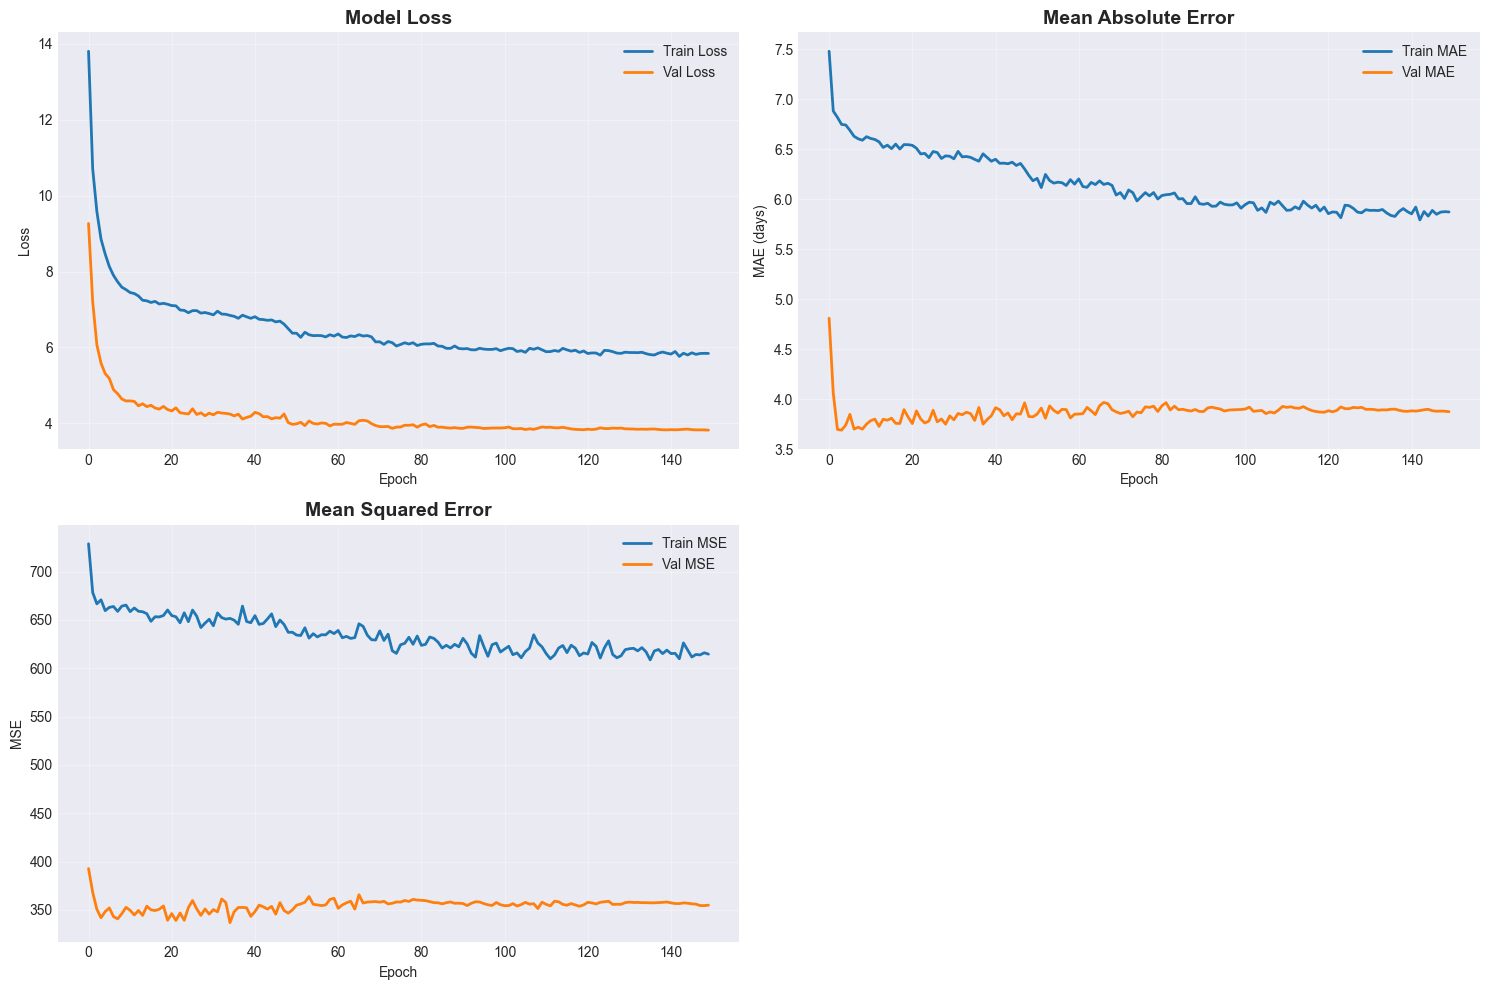

✅ Predictions plot saved: predictions.png


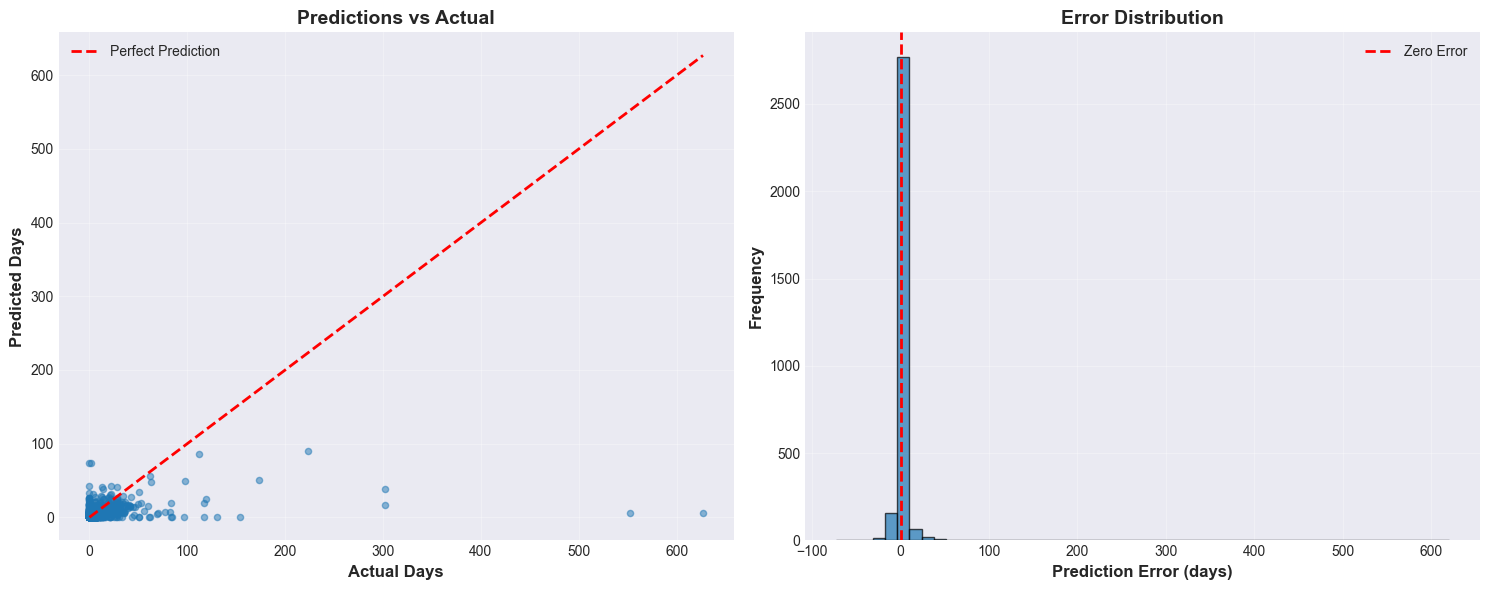

⚠️  Step 10: Create visualizations


In [19]:
# Step 10: Visualize
plot_training_history(history, save_path='training_history.png')
plot_predictions(data['y_test'], results['predictions'], save_path='predictions.png')
print("⚠️  Step 10: Create visualizations")


## 🔮 Quick Inference Example

In [20]:
"""
QUICK INFERENCE EXAMPLE

Use this to load a saved model and make predictions
"""

# Load the latest saved model
model_components = load_complete_model()

# Make predictions on new data
predictions = predict_new_data(model_components, new_df)

print(f"Predictions: {predictions}")

print("\n✅ Inference example ready!")
print("\nUncomment to load model and make predictions.")


📂 Loading model from: models\latest_model.h5


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models\latest_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## 📋 Summary

### Your Current Performance (Excellent! 🎉)
- **MAE: 3.59 days** (Much better than baseline 6.17 days)
- **Within 7 days: 91.9%** (Outstanding!)
- **Within 14 days: 96.3%** (Excellent precision)

### What This Notebook Provides

1. **Enhanced Architecture**
   - Bidirectional LSTM (128 → 64 units)
   - Batch normalization
   - L1/L2 regularization
   - Dropout for regularization

2. **Comprehensive Model Saving**
   - ✅ Full model (.h5)
   - ✅ SavedModel format (TensorFlow)
   - ✅ Weights only
   - ✅ Architecture (JSON)
   - ✅ Training history
   - ✅ Metadata
   - ✅ Scaler
   - ✅ Feature names

3. **Training Features**
   - Early stopping
   - Learning rate reduction
   - Model checkpointing
   - CSV logging
   - TensorBoard support

4. **Easy Inference**
   - Simple model loading
   - Prediction on new data
   - All preprocessing handled automatically

### Next Steps

1. Load your data
2. Run the pipeline
3. Model will be saved automatically
4. Use `load_complete_model()` for inference
5. Share the `models/` directory for deployment

**Your model is already performing excellently! This notebook helps you save and deploy it properly.** 🚀